In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("joebeachcapital/realwaste")

print("Path to dataset files:", path)

100%|██████████| 657M/657M [00:05<00:00, 136MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/joebeachcapital/realwaste/versions/1


In [ ]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v3_small
import timm

from PIL import Image
from tqdm import tqdm

# Optionally use albumentations for stronger augmentations
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    ALBUMENTATIONS = True
except Exception:
    ALBUMENTATIONS = False

In [ ]:
from pathlib import Path
DATA_DIR = Path(path)  # the path returned by kagglehub

#CONFIG
DATA_DIR = Path("/root/.cache/kagglehub/datasets/joebeachcapital/realwaste/versions/1/realwaste-main/RealWaste")  # update if different
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4
NUM_CLASSES = 9
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 30
LR = 2e-4
WEIGHT_DECAY = 1e-4
PIN_MEMORY = True

# Mapping classes (make sure order matches your folder names)
CLASS_NAMES = [
    'Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash',
    'Paper', 'Plastic', 'Textile Trash', 'Vegetation'
]
CLASS_TO_IDX = {c: i for i, c in enumerate(CLASS_NAMES)}

In [ ]:
#UTIL
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

In [ ]:
# DATASET
class WasteDataset(Dataset):
    def __init__(self, items, labels, transforms=None):
        self.items = items
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path = self.items[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)
        if self.transforms:
            if ALBUMENTATIONS and isinstance(self.transforms, A.Compose):
                augmented = self.transforms(image=img)
                img = augmented['image']
            else:
                img = transforms.ToTensor()(Image.fromarray(img))
        else:
            img = transforms.ToTensor()(Image.fromarray(img))
        return img, label


# Build filelist by reading folders inside DATA_DIR/train
def build_file_list(data_dir):
    # If dataset arranged as train/<class>/*.jpg
    items = []
    labels = []
    for cls in CLASS_NAMES:
        cls_dir = data_dir / 'train' / cls
        if not cls_dir.exists():
            # try alternative path
            cls_dir = data_dir / cls
        if not cls_dir.exists():
            print(f"Warning: expected folder for class {cls} not found at {cls_dir}")
            continue
        imgs = list(cls_dir.glob('**/*'))
        imgs = [p for p in imgs if p.suffix.lower() in ['.jpg', '.jpeg', '.png']]
        items += imgs
        labels += [CLASS_TO_IDX[cls]] * len(imgs)
    return items, labels

items, labels = build_file_list(DATA_DIR)
print(f"Found {len(items)} images")

# Train/val split (stratified)
train_idx, val_idx = train_test_split(
    np.arange(len(items)), test_size=0.15, stratify=labels, random_state=SEED
)
train_items = [items[i] for i in train_idx]
val_items = [items[i] for i in val_idx]
train_labels = [labels[i] for i in train_idx]
val_labels = [labels[i] for i in val_idx]

Found 4752 images


In [ ]:
# TRANSFORMS
if ALBUMENTATIONS:
    train_transform = A.Compose([
        A.RandomResizedCrop(
            size=(IMG_SIZE, IMG_SIZE),    # Correct tuple syntax
            scale=(0.8, 1.0),
            ratio=(0.75, 1.33),
            p=1.0
        ),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(
            height=IMG_SIZE,
            width=IMG_SIZE
        ),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2()
    ])

else:
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        )
    ])

    val_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        )
    ])

train_ds = WasteDataset(train_items, train_labels, transforms=train_transform)
val_ds = WasteDataset(val_items, val_labels, transforms=val_transform)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# MODEL
class HybridCNNTransformer(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, cnn_out_dim=576, vit_out_dim=448):
        super().__init__()
        # MobileNetV3 small backbone
        self.cnn = mobilenet_v3_small(pretrained=True)
        # remove classifier and global pooling
        self.cnn.classifier = nn.Identity()

        # Many torchvision MobileNet implementations end with a global pooling and a classifier
        # We'll take the feature map before classifier by forwarding and applying adaptive pool
        self.cnn_pool = nn.AdaptiveAvgPool2d(1)

        # TinyViT from timm
        # Ensure the timm model name exists on your timm version. Example name: 'tiny_vit_11m_224'
        self.vit = timm.create_model('tiny_vit_11m_224', pretrained=True)
        # remove classifier head
        if hasattr(self.vit, 'head'):
            self.vit.head = nn.Identity()
        elif hasattr(self.vit, 'fc'):
            self.vit.fc = nn.Identity()

        # Add pooling for the ViT branch's feature maps if its head is an Identity
        self.vit_pool = nn.AdaptiveAvgPool2d(1)

        # Final fused classifier
        self.fc = nn.Linear(cnn_out_dim + vit_out_dim, num_classes)

    def forward(self, x):
        # CNN path
        # get feature map from mobilenet: pass through features
        # torchvision mobilenet_v3_small has .features module
        cnn_feat_map = self.cnn.features(x)  # [B, C, H, W]
        pooled = self.cnn_pool(cnn_feat_map).view(x.size(0), -1)  # [B, cnn_out_dim]

        # ViT path: pass image directly to vit encoder (timm model expects images)
        # If vit.head is Identity, it might return the feature maps from the last stage [B, C, H, W]
        vit_feat_raw = self.vit(x)
        # Apply pooling and flatten to get [B, vit_out_dim]
        vit_feat = self.vit_pool(vit_feat_raw).view(x.size(0), -1)

        # Concatenate and classify
        fused = torch.cat([pooled, vit_feat], dim=1)
        out = self.fc(fused)
        return out

model = HybridCNNTransformer().to(DEVICE)
print(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


HybridCNNTransformer(
  (cnn): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2):

In [ ]:
#TRAINING HELPERS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

from collections import defaultdict

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in tqdm(loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss / total, correct / total


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
    report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES, digits=4)
    return running_loss / total, correct / total, report

In [ ]:
# ------------------------ TRAIN LOOP ------------------------
best_val_acc = 0.0
save_dir = Path('./checkpoints')
save_dir.mkdir(parents=True, exist_ok=True)

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc, report = validate(model, val_loader, criterion, DEVICE)
    print(f"Epoch {epoch+1}/{EPOCHS}  Train loss: {train_loss:.4f}  Train acc: {train_acc:.4f}  Val loss: {val_loss:.4f}  Val acc: {val_acc:.4f}")
    print(report)

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'epoch': epoch, 'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict()}, save_dir / 'best.pt')

  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:04<00:00,  5.60it/s]


Epoch 1/30  Train loss: 1.2707  Train acc: 0.5724  Val loss: 0.5447  Val acc: 0.8233
                     precision    recall  f1-score   support

          Cardboard     0.8182    0.7826    0.8000        69
      Food Organics     0.8026    0.9839    0.8841        62
              Glass     0.9811    0.8254    0.8966        63
              Metal     0.8268    0.8824    0.8537       119
Miscellaneous Trash     0.6812    0.6351    0.6573        74
              Paper     0.8767    0.8533    0.8649        75
            Plastic     0.7632    0.8406    0.8000       138
      Textile Trash     0.8621    0.5208    0.6494        48
         Vegetation     0.9265    0.9692    0.9474        65

           accuracy                         0.8233       713
          macro avg     0.8376    0.8104    0.8170       713
       weighted avg     0.8268    0.8233    0.8201       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  7.02it/s]


Epoch 2/30  Train loss: 0.5824  Train acc: 0.8032  Val loss: 0.3480  Val acc: 0.8850
                     precision    recall  f1-score   support

          Cardboard     0.8873    0.9130    0.9000        69
      Food Organics     0.9385    0.9839    0.9606        62
              Glass     1.0000    0.8889    0.9412        63
              Metal     0.8156    0.9664    0.8846       119
Miscellaneous Trash     0.8167    0.6622    0.7313        74
              Paper     0.9079    0.9200    0.9139        75
            Plastic     0.8939    0.8551    0.8741       138
      Textile Trash     0.7708    0.7708    0.7708        48
         Vegetation     0.9844    0.9692    0.9767        65

           accuracy                         0.8850       713
          macro avg     0.8906    0.8811    0.8837       713
       weighted avg     0.8869    0.8850    0.8836       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.88it/s]


Epoch 3/30  Train loss: 0.4070  Train acc: 0.8589  Val loss: 0.2832  Val acc: 0.9046
                     precision    recall  f1-score   support

          Cardboard     0.8571    0.9565    0.9041        69
      Food Organics     0.9062    0.9355    0.9206        62
              Glass     1.0000    0.9206    0.9587        63
              Metal     0.8960    0.9412    0.9180       119
Miscellaneous Trash     0.8833    0.7162    0.7910        74
              Paper     0.8961    0.9200    0.9079        75
            Plastic     0.9254    0.8986    0.9118       138
      Textile Trash     0.8367    0.8542    0.8454        48
         Vegetation     0.9275    0.9846    0.9552        65

           accuracy                         0.9046       713
          macro avg     0.9032    0.9030    0.9014       713
       weighted avg     0.9056    0.9046    0.9035       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:04<00:00,  5.54it/s]


Epoch 4/30  Train loss: 0.3085  Train acc: 0.8955  Val loss: 0.2397  Val acc: 0.9243
                     precision    recall  f1-score   support

          Cardboard     0.9385    0.8841    0.9104        69
      Food Organics     0.9375    0.9677    0.9524        62
              Glass     1.0000    0.9524    0.9756        63
              Metal     0.9120    0.9580    0.9344       119
Miscellaneous Trash     0.8378    0.8378    0.8378        74
              Paper     0.9146    1.0000    0.9554        75
            Plastic     0.9231    0.8696    0.8955       138
      Textile Trash     0.8800    0.9167    0.8980        48
         Vegetation     1.0000    0.9692    0.9844        65

           accuracy                         0.9243       713
          macro avg     0.9271    0.9284    0.9271       713
       weighted avg     0.9251    0.9243    0.9241       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.48it/s]


Epoch 5/30  Train loss: 0.2453  Train acc: 0.9183  Val loss: 0.2235  Val acc: 0.9341
                     precision    recall  f1-score   support

          Cardboard     0.9155    0.9420    0.9286        69
      Food Organics     1.0000    0.9839    0.9919        62
              Glass     1.0000    0.9524    0.9756        63
              Metal     0.9391    0.9076    0.9231       119
Miscellaneous Trash     0.8472    0.8243    0.8356        74
              Paper     0.9146    1.0000    0.9554        75
            Plastic     0.9143    0.9275    0.9209       138
      Textile Trash     0.9375    0.9375    0.9375        48
         Vegetation     0.9844    0.9692    0.9767        65

           accuracy                         0.9341       713
          macro avg     0.9392    0.9383    0.9384       713
       weighted avg     0.9346    0.9341    0.9340       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  7.15it/s]


Epoch 6/30  Train loss: 0.1771  Train acc: 0.9433  Val loss: 0.2091  Val acc: 0.9327
                     precision    recall  f1-score   support

          Cardboard     0.9848    0.9420    0.9630        69
      Food Organics     0.9524    0.9677    0.9600        62
              Glass     0.9841    0.9841    0.9841        63
              Metal     0.9391    0.9076    0.9231       119
Miscellaneous Trash     0.8676    0.7973    0.8310        74
              Paper     0.9861    0.9467    0.9660        75
            Plastic     0.8808    0.9638    0.9204       138
      Textile Trash     0.8800    0.9167    0.8980        48
         Vegetation     0.9692    0.9692    0.9692        65

           accuracy                         0.9327       713
          macro avg     0.9383    0.9328    0.9350       713
       weighted avg     0.9337    0.9327    0.9325       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.99it/s]


Epoch 7/30  Train loss: 0.1525  Train acc: 0.9505  Val loss: 0.2060  Val acc: 0.9327
                     precision    recall  f1-score   support

          Cardboard     0.9296    0.9565    0.9429        69
      Food Organics     0.9683    0.9839    0.9760        62
              Glass     0.9130    1.0000    0.9545        63
              Metal     0.8898    0.9496    0.9187       119
Miscellaneous Trash     0.9014    0.8649    0.8828        74
              Paper     0.9459    0.9333    0.9396        75
            Plastic     0.9457    0.8841    0.9139       138
      Textile Trash     0.9773    0.8958    0.9348        48
         Vegetation     0.9692    0.9692    0.9692        65

           accuracy                         0.9327       713
          macro avg     0.9378    0.9375    0.9369       713
       weighted avg     0.9336    0.9327    0.9324       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  7.02it/s]


Epoch 8/30  Train loss: 0.1395  Train acc: 0.9549  Val loss: 0.2071  Val acc: 0.9397
                     precision    recall  f1-score   support

          Cardboard     0.9041    0.9565    0.9296        69
      Food Organics     0.9688    1.0000    0.9841        62
              Glass     1.0000    0.9841    0.9920        63
              Metal     0.9561    0.9160    0.9356       119
Miscellaneous Trash     0.8553    0.8784    0.8667        74
              Paper     0.9726    0.9467    0.9595        75
            Plastic     0.9130    0.9130    0.9130       138
      Textile Trash     0.9200    0.9583    0.9388        48
         Vegetation     1.0000    0.9692    0.9844        65

           accuracy                         0.9397       713
          macro avg     0.9433    0.9469    0.9448       713
       weighted avg     0.9406    0.9397    0.9399       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  5.78it/s]


Epoch 9/30  Train loss: 0.1159  Train acc: 0.9596  Val loss: 0.2003  Val acc: 0.9397
                     precision    recall  f1-score   support

          Cardboard     0.9692    0.9130    0.9403        69
      Food Organics     0.9538    1.0000    0.9764        62
              Glass     0.9545    1.0000    0.9767        63
              Metal     0.9397    0.9160    0.9277       119
Miscellaneous Trash     0.9242    0.8243    0.8714        74
              Paper     0.9136    0.9867    0.9487        75
            Plastic     0.9220    0.9420    0.9319       138
      Textile Trash     0.9000    0.9375    0.9184        48
         Vegetation     1.0000    0.9692    0.9844        65

           accuracy                         0.9397       713
          macro avg     0.9419    0.9432    0.9418       713
       weighted avg     0.9401    0.9397    0.9392       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.12it/s]


Epoch 10/30  Train loss: 0.0993  Train acc: 0.9646  Val loss: 0.2016  Val acc: 0.9355
                     precision    recall  f1-score   support

          Cardboard     0.9559    0.9420    0.9489        69
      Food Organics     0.9839    0.9839    0.9839        62
              Glass     0.9844    1.0000    0.9921        63
              Metal     0.8898    0.9496    0.9187       119
Miscellaneous Trash     0.9062    0.7838    0.8406        74
              Paper     0.8902    0.9733    0.9299        75
            Plastic     0.9343    0.9275    0.9309       138
      Textile Trash     0.9762    0.8542    0.9111        48
         Vegetation     0.9701    1.0000    0.9848        65

           accuracy                         0.9355       713
          macro avg     0.9434    0.9349    0.9379       713
       weighted avg     0.9362    0.9355    0.9347       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.54it/s]


Epoch 11/30  Train loss: 0.0856  Train acc: 0.9718  Val loss: 0.1776  Val acc: 0.9411
                     precision    recall  f1-score   support

          Cardboard     0.9385    0.8841    0.9104        69
      Food Organics     1.0000    1.0000    1.0000        62
              Glass     0.9516    0.9365    0.9440        63
              Metal     0.9732    0.9160    0.9437       119
Miscellaneous Trash     0.9286    0.8784    0.9028        74
              Paper     0.9012    0.9733    0.9359        75
            Plastic     0.8859    0.9565    0.9199       138
      Textile Trash     0.9583    0.9583    0.9583        48
         Vegetation     1.0000    0.9846    0.9922        65

           accuracy                         0.9411       713
          macro avg     0.9486    0.9431    0.9453       713
       weighted avg     0.9426    0.9411    0.9411       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.37it/s]


Epoch 12/30  Train loss: 0.0791  Train acc: 0.9762  Val loss: 0.1675  Val acc: 0.9425
                     precision    recall  f1-score   support

          Cardboard     0.9420    0.9420    0.9420        69
      Food Organics     0.9836    0.9677    0.9756        62
              Glass     0.9545    1.0000    0.9767        63
              Metal     0.9483    0.9244    0.9362       119
Miscellaneous Trash     0.9000    0.8514    0.8750        74
              Paper     0.9610    0.9867    0.9737        75
            Plastic     0.9161    0.9493    0.9324       138
      Textile Trash     0.9545    0.8750    0.9130        48
         Vegetation     0.9552    0.9846    0.9697        65

           accuracy                         0.9425       713
          macro avg     0.9461    0.9423    0.9438       713
       weighted avg     0.9425    0.9425    0.9421       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.09it/s]


Epoch 13/30  Train loss: 0.0731  Train acc: 0.9770  Val loss: 0.1938  Val acc: 0.9439
                     precision    recall  f1-score   support

          Cardboard     0.9296    0.9565    0.9429        69
      Food Organics     0.9688    1.0000    0.9841        62
              Glass     1.0000    1.0000    1.0000        63
              Metal     0.8915    0.9664    0.9274       119
Miscellaneous Trash     0.8750    0.8514    0.8630        74
              Paper     0.9863    0.9600    0.9730        75
            Plastic     0.9474    0.9130    0.9299       138
      Textile Trash     0.9556    0.8958    0.9247        48
         Vegetation     1.0000    0.9692    0.9844        65

           accuracy                         0.9439       713
          macro avg     0.9504    0.9458    0.9477       713
       weighted avg     0.9448    0.9439    0.9439       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.98it/s]


Epoch 14/30  Train loss: 0.0628  Train acc: 0.9790  Val loss: 0.1595  Val acc: 0.9523
                     precision    recall  f1-score   support

          Cardboard     0.9178    0.9710    0.9437        69
      Food Organics     0.9839    0.9839    0.9839        62
              Glass     1.0000    1.0000    1.0000        63
              Metal     0.9350    0.9664    0.9504       119
Miscellaneous Trash     0.9296    0.8919    0.9103        74
              Paper     0.9241    0.9733    0.9481        75
            Plastic     0.9549    0.9203    0.9373       138
      Textile Trash     1.0000    0.8958    0.9451        48
         Vegetation     0.9697    0.9846    0.9771        65

           accuracy                         0.9523       713
          macro avg     0.9572    0.9541    0.9551       713
       weighted avg     0.9530    0.9523    0.9522       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.84it/s]


Epoch 15/30  Train loss: 0.0478  Train acc: 0.9851  Val loss: 0.1906  Val acc: 0.9481
                     precision    recall  f1-score   support

          Cardboard     0.9559    0.9420    0.9489        69
      Food Organics     1.0000    0.9839    0.9919        62
              Glass     0.9841    0.9841    0.9841        63
              Metal     0.9187    0.9496    0.9339       119
Miscellaneous Trash     0.9130    0.8514    0.8811        74
              Paper     0.9730    0.9600    0.9664        75
            Plastic     0.9281    0.9348    0.9314       138
      Textile Trash     0.9216    0.9792    0.9495        48
         Vegetation     0.9846    0.9846    0.9846        65

           accuracy                         0.9481       713
          macro avg     0.9532    0.9522    0.9524       713
       weighted avg     0.9483    0.9481    0.9480       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:04<00:00,  5.43it/s]


Epoch 16/30  Train loss: 0.0485  Train acc: 0.9834  Val loss: 0.2200  Val acc: 0.9327
                     precision    recall  f1-score   support

          Cardboard     0.9296    0.9565    0.9429        69
      Food Organics     0.9836    0.9677    0.9756        62
              Glass     0.9692    1.0000    0.9844        63
              Metal     0.8837    0.9580    0.9194       119
Miscellaneous Trash     0.8611    0.8378    0.8493        74
              Paper     0.9865    0.9733    0.9799        75
            Plastic     0.9333    0.9130    0.9231       138
      Textile Trash     0.9737    0.7708    0.8605        48
         Vegetation     0.9412    0.9846    0.9624        65

           accuracy                         0.9327       713
          macro avg     0.9402    0.9291    0.9330       713
       weighted avg     0.9338    0.9327    0.9320       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.93it/s]


Epoch 17/30  Train loss: 0.0480  Train acc: 0.9842  Val loss: 0.2324  Val acc: 0.9453
                     precision    recall  f1-score   support

          Cardboard     0.9559    0.9420    0.9489        69
      Food Organics     0.9677    0.9677    0.9677        62
              Glass     0.9545    1.0000    0.9767        63
              Metal     0.9322    0.9244    0.9283       119
Miscellaneous Trash     0.9143    0.8649    0.8889        74
              Paper     0.9487    0.9867    0.9673        75
            Plastic     0.9220    0.9420    0.9319       138
      Textile Trash     1.0000    0.9167    0.9565        48
         Vegetation     0.9697    0.9846    0.9771        65

           accuracy                         0.9453       713
          macro avg     0.9517    0.9477    0.9493       713
       weighted avg     0.9454    0.9453    0.9451       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.87it/s]


Epoch 18/30  Train loss: 0.0614  Train acc: 0.9785  Val loss: 0.2230  Val acc: 0.9369
                     precision    recall  f1-score   support

          Cardboard     0.9661    0.8261    0.8906        69
      Food Organics     0.9688    1.0000    0.9841        62
              Glass     0.9545    1.0000    0.9767        63
              Metal     0.9167    0.9244    0.9205       119
Miscellaneous Trash     0.8986    0.8378    0.8671        74
              Paper     0.8810    0.9867    0.9308        75
            Plastic     0.9286    0.9420    0.9353       138
      Textile Trash     0.9787    0.9583    0.9684        48
         Vegetation     1.0000    0.9846    0.9922        65

           accuracy                         0.9369       713
          macro avg     0.9437    0.9400    0.9407       713
       weighted avg     0.9378    0.9369    0.9363       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.79it/s]


Epoch 19/30  Train loss: 0.0467  Train acc: 0.9829  Val loss: 0.1816  Val acc: 0.9481
                     precision    recall  f1-score   support

          Cardboard     0.9054    0.9710    0.9371        69
      Food Organics     1.0000    0.9677    0.9836        62
              Glass     0.9692    1.0000    0.9844        63
              Metal     0.9407    0.9328    0.9367       119
Miscellaneous Trash     0.9028    0.8784    0.8904        74
              Paper     0.9359    0.9733    0.9542        75
            Plastic     0.9552    0.9275    0.9412       138
      Textile Trash     0.9583    0.9583    0.9583        48
         Vegetation     0.9844    0.9692    0.9767        65

           accuracy                         0.9481       713
          macro avg     0.9502    0.9531    0.9514       713
       weighted avg     0.9485    0.9481    0.9480       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.11it/s]


Epoch 20/30  Train loss: 0.0504  Train acc: 0.9851  Val loss: 0.1933  Val acc: 0.9523
                     precision    recall  f1-score   support

          Cardboard     0.9306    0.9710    0.9504        69
      Food Organics     1.0000    0.9677    0.9836        62
              Glass     0.9839    0.9683    0.9760        63
              Metal     0.9412    0.9412    0.9412       119
Miscellaneous Trash     0.9286    0.8784    0.9028        74
              Paper     0.9726    0.9467    0.9595        75
            Plastic     0.9424    0.9493    0.9458       138
      Textile Trash     0.9231    1.0000    0.9600        48
         Vegetation     0.9697    0.9846    0.9771        65

           accuracy                         0.9523       713
          macro avg     0.9547    0.9563    0.9551       713
       weighted avg     0.9527    0.9523    0.9522       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.85it/s]


Epoch 21/30  Train loss: 0.0567  Train acc: 0.9824  Val loss: 0.2004  Val acc: 0.9467
                     precision    recall  f1-score   support

          Cardboard     0.9692    0.9130    0.9403        69
      Food Organics     0.9531    0.9839    0.9683        62
              Glass     0.9844    1.0000    0.9921        63
              Metal     0.9333    0.9412    0.9372       119
Miscellaneous Trash     0.9014    0.8649    0.8828        74
              Paper     0.9733    0.9733    0.9733        75
            Plastic     0.9286    0.9420    0.9353       138
      Textile Trash     0.9375    0.9375    0.9375        48
         Vegetation     0.9697    0.9846    0.9771        65

           accuracy                         0.9467       713
          macro avg     0.9501    0.9489    0.9493       713
       weighted avg     0.9466    0.9467    0.9465       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.99it/s]


Epoch 22/30  Train loss: 0.0362  Train acc: 0.9894  Val loss: 0.2039  Val acc: 0.9509
                     precision    recall  f1-score   support

          Cardboard     0.9571    0.9710    0.9640        69
      Food Organics     0.9688    1.0000    0.9841        62
              Glass     1.0000    1.0000    1.0000        63
              Metal     0.8846    0.9664    0.9237       119
Miscellaneous Trash     0.9677    0.8108    0.8824        74
              Paper     0.9730    0.9600    0.9664        75
            Plastic     0.9420    0.9420    0.9420       138
      Textile Trash     0.9388    0.9583    0.9485        48
         Vegetation     1.0000    0.9692    0.9844        65

           accuracy                         0.9509       713
          macro avg     0.9591    0.9531    0.9551       713
       weighted avg     0.9523    0.9509    0.9505       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:04<00:00,  5.53it/s]


Epoch 23/30  Train loss: 0.0265  Train acc: 0.9911  Val loss: 0.1959  Val acc: 0.9509
                     precision    recall  f1-score   support

          Cardboard     0.9559    0.9420    0.9489        69
      Food Organics     1.0000    1.0000    1.0000        62
              Glass     0.9692    1.0000    0.9844        63
              Metal     0.9412    0.9412    0.9412       119
Miscellaneous Trash     0.9155    0.8784    0.8966        74
              Paper     0.9863    0.9600    0.9730        75
            Plastic     0.9161    0.9493    0.9324       138
      Textile Trash     0.9348    0.8958    0.9149        48
         Vegetation     0.9848    1.0000    0.9924        65

           accuracy                         0.9509       713
          macro avg     0.9560    0.9519    0.9537       713
       weighted avg     0.9510    0.9509    0.9508       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  7.01it/s]


Epoch 24/30  Train loss: 0.0309  Train acc: 0.9901  Val loss: 0.2359  Val acc: 0.9439
                     precision    recall  f1-score   support

          Cardboard     0.9412    0.9275    0.9343        69
      Food Organics     1.0000    0.9839    0.9919        62
              Glass     1.0000    0.9841    0.9920        63
              Metal     0.9113    0.9496    0.9300       119
Miscellaneous Trash     0.9155    0.8784    0.8966        74
              Paper     0.9467    0.9467    0.9467        75
            Plastic     0.9338    0.9203    0.9270       138
      Textile Trash     0.9020    0.9583    0.9293        48
         Vegetation     0.9846    0.9846    0.9846        65

           accuracy                         0.9439       713
          macro avg     0.9483    0.9482    0.9480       713
       weighted avg     0.9443    0.9439    0.9439       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  7.02it/s]


Epoch 25/30  Train loss: 0.0306  Train acc: 0.9898  Val loss: 0.2014  Val acc: 0.9523
                     precision    recall  f1-score   support

          Cardboard     0.9155    0.9420    0.9286        69
      Food Organics     0.9839    0.9839    0.9839        62
              Glass     1.0000    1.0000    1.0000        63
              Metal     0.9280    0.9748    0.9508       119
Miscellaneous Trash     0.9692    0.8514    0.9065        74
              Paper     0.9600    0.9600    0.9600        75
            Plastic     0.9412    0.9275    0.9343       138
      Textile Trash     0.9216    0.9792    0.9495        48
         Vegetation     0.9846    0.9846    0.9846        65

           accuracy                         0.9523       713
          macro avg     0.9560    0.9559    0.9554       713
       weighted avg     0.9529    0.9523    0.9520       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.72it/s]


Epoch 26/30  Train loss: 0.0392  Train acc: 0.9879  Val loss: 0.2524  Val acc: 0.9481
                     precision    recall  f1-score   support

          Cardboard     0.9701    0.9420    0.9559        69
      Food Organics     1.0000    0.9839    0.9919        62
              Glass     1.0000    1.0000    1.0000        63
              Metal     0.8915    0.9664    0.9274       119
Miscellaneous Trash     0.9385    0.8243    0.8777        74
              Paper     0.9863    0.9600    0.9730        75
            Plastic     0.9281    0.9348    0.9314       138
      Textile Trash     0.9200    0.9583    0.9388        48
         Vegetation     0.9697    0.9846    0.9771        65

           accuracy                         0.9481       713
          macro avg     0.9560    0.9505    0.9526       713
       weighted avg     0.9491    0.9481    0.9479       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:04<00:00,  5.36it/s]


Epoch 27/30  Train loss: 0.0447  Train acc: 0.9839  Val loss: 0.2474  Val acc: 0.9481
                     precision    recall  f1-score   support

          Cardboard     0.9839    0.8841    0.9313        69
      Food Organics     0.9538    1.0000    0.9764        62
              Glass     0.9844    1.0000    0.9921        63
              Metal     0.9256    0.9412    0.9333       119
Miscellaneous Trash     0.9701    0.8784    0.9220        74
              Paper     0.9359    0.9733    0.9542        75
            Plastic     0.9041    0.9565    0.9296       138
      Textile Trash     1.0000    0.9375    0.9677        48
         Vegetation     0.9692    0.9692    0.9692        65

           accuracy                         0.9481       713
          macro avg     0.9586    0.9489    0.9529       713
       weighted avg     0.9494    0.9481    0.9480       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  7.00it/s]


Epoch 28/30  Train loss: 0.0321  Train acc: 0.9898  Val loss: 0.2379  Val acc: 0.9439
                     precision    recall  f1-score   support

          Cardboard     0.9412    0.9275    0.9343        69
      Food Organics     1.0000    0.9516    0.9752        62
              Glass     1.0000    0.9841    0.9920        63
              Metal     0.9333    0.9412    0.9372       119
Miscellaneous Trash     0.9403    0.8514    0.8936        74
              Paper     0.9474    0.9600    0.9536        75
            Plastic     0.8980    0.9565    0.9263       138
      Textile Trash     0.9783    0.9375    0.9574        48
         Vegetation     0.9412    0.9846    0.9624        65

           accuracy                         0.9439       713
          macro avg     0.9533    0.9438    0.9480       713
       weighted avg     0.9449    0.9439    0.9438       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.63it/s]


Epoch 29/30  Train loss: 0.0336  Train acc: 0.9901  Val loss: 0.2553  Val acc: 0.9411
                     precision    recall  f1-score   support

          Cardboard     0.9697    0.9275    0.9481        69
      Food Organics     0.9394    1.0000    0.9688        62
              Glass     0.9692    1.0000    0.9844        63
              Metal     0.8968    0.9496    0.9224       119
Miscellaneous Trash     0.9385    0.8243    0.8777        74
              Paper     0.9481    0.9733    0.9605        75
            Plastic     0.9265    0.9130    0.9197       138
      Textile Trash     0.9388    0.9583    0.9485        48
         Vegetation     1.0000    0.9692    0.9844        65

           accuracy                         0.9411       713
          macro avg     0.9474    0.9462    0.9461       713
       weighted avg     0.9417    0.9411    0.9407       713



  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 23/23 [00:03<00:00,  6.55it/s]

Epoch 30/30  Train loss: 0.0448  Train acc: 0.9856  Val loss: 0.2235  Val acc: 0.9495
                     precision    recall  f1-score   support

          Cardboard     0.9412    0.9275    0.9343        69
      Food Organics     0.9841    1.0000    0.9920        62
              Glass     1.0000    0.9524    0.9756        63
              Metal     0.9655    0.9412    0.9532       119
Miscellaneous Trash     0.9167    0.8919    0.9041        74
              Paper     0.9605    0.9733    0.9669        75
            Plastic     0.9028    0.9420    0.9220       138
      Textile Trash     0.9375    0.9375    0.9375        48
         Vegetation     0.9848    1.0000    0.9924        65

           accuracy                         0.9495       713
          macro avg     0.9548    0.9518    0.9531       713
       weighted avg     0.9500    0.9495    0.9495       713



In [ ]:
#INFERENCE

def predict_image(model, image_path, device, transform=None):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    if transform is None:
        img = val_transform(Image.fromarray(np.array(img)))
    else:
        if ALBUMENTATIONS and isinstance(transform, A.Compose):
            img = transform(image=np.array(img))['image']
        else:
            img = transform(img)
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(img)
        probs = nn.functional.softmax(out, dim=1).cpu().numpy()[0]
        pred = int(probs.argmax())
    return CLASS_NAMES[pred], probs

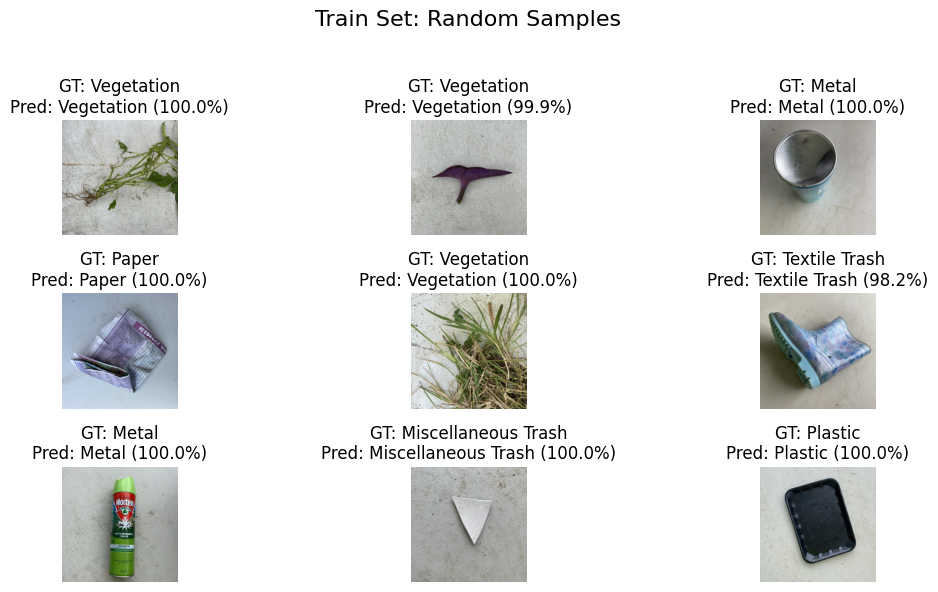

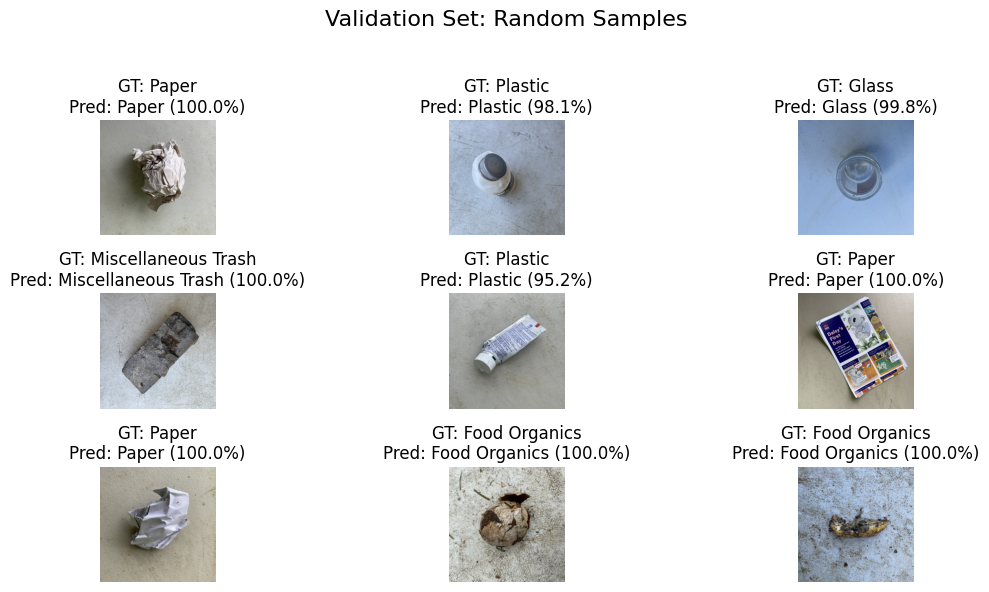

In [ ]:
import random
import matplotlib.pyplot as plt
import torch
from PIL import Image
import numpy as np

# Ensure model is on correct device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)
model.eval()

# Function to preprocess image for both Albumentations and TorchVision
def preprocess_image(img_path, transform):
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    # Albumentations transform
    if 'albumentations' in str(type(transform)).lower():
        augmented = transform(image=img_np)
        tensor = augmented["image"]
    else:
        # TorchVision transform
        tensor = transform(img)

    return tensor.unsqueeze(0)

# Prediction function
def predict_image(img_path, model, transform, class_names, device):
    tensor = preprocess_image(img_path, transform).to(device)
    with torch.no_grad():
        out = model(tensor)
        probs = torch.softmax(out, dim=1)[0]
        conf, pred = torch.max(probs, dim=0)
    return class_names[pred.item()], conf.item()

# Plot function
def plot_images(image_paths, gt_labels, preds, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)
    for i, path in enumerate(image_paths):
        plt.subplot(3, 3, i+1)
        img = Image.open(path).convert("RGB")
        plt.imshow(img)
        pred_label, pred_conf = preds[i]
        plt.title(f"GT: {gt_labels[i]}\nPred: {pred_label} ({pred_conf*100:.1f}%)")
        plt.axis("off")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# Grab 9 random samples from train & val
train_samples = random.sample(train_items, 9)
val_samples   = random.sample(val_items,   9)

# Inference on train samples
train_preds = []
train_gt    = []
for p in train_samples:
    # get GT label from your mapping
    gt_label = CLASS_NAMES[train_labels[train_items.index(p)]]
    pred_label, conf = predict_image(p, model, val_transform, CLASS_NAMES, DEVICE)
    train_gt.append(gt_label)
    train_preds.append((pred_label, conf))

plot_images(train_samples, train_gt, train_preds, "Train Set: Random Samples")

# Inference on val samples
val_preds = []
val_gt    = []
for p in val_samples:
    gt_label = CLASS_NAMES[val_labels[val_items.index(p)]]
    pred_label, conf = predict_image(p, model, val_transform, CLASS_NAMES, DEVICE)
    val_gt.append(gt_label)
    val_preds.append((pred_label, conf))

plot_images(val_samples, val_gt, val_preds, "Validation Set: Random Samples")


In [ ]:
from google.colab import files
from PIL import Image
import torch
import torchvision.transforms as T
import numpy as np

# 1) Ask user to upload image
print("Upload an image to classify:")
uploaded = files.upload()  # will open file dialog

# Get the first uploaded file path
image_path = list(uploaded.keys())[0]
print("Uploaded file:", image_path)

# 2) Prepare the same preprocessing as validation
IMG_SIZE = 224
transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225))
])

# 3) Load the image
img = Image.open(image_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0)  # add batch dimension

# 4) Load your saved model
# Replace this path with wherever your best checkpoint is saved
checkpoint = torch.load("checkpoints/best.pt", map_location="cpu")

model = HybridCNNTransformer(num_classes=9)  # import model class
model.load_state_dict(checkpoint["model_state"])
model.eval()

# 5) Run inference
with torch.no_grad():
    output = model(input_tensor)              # shape: [1, num_classes]
    probs = torch.softmax(output, dim=1)[0]    # probabilities
    conf, pred = torch.max(probs, dim=0)       # highest score

# 6) Class names (same as training)
CLASS_NAMES = [
    'Cardboard', 'Food Organics', 'Glass', 'Metal',
    'Miscellaneous Trash', 'Paper', 'Plastic',
    'Textile Trash', 'Vegetation'
]

print(f"Predicted class : {CLASS_NAMES[pred]}")
print(f"Confidence      : {conf.item()*100:.2f}%")


Upload an image to classify:


Saving WhatsApp Image 2025-12-11 at 15.27.04_31cb8c92.jpg to WhatsApp Image 2025-12-11 at 15.27.04_31cb8c92 (1).jpg
Uploaded file: WhatsApp Image 2025-12-11 at 15.27.04_31cb8c92 (1).jpg


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted class : Plastic
Confidence      : 82.71%


In [ ]:
# 1) TorchScript tracing (good for mobile via libtorch)
example_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
model.eval()
traced = torch.jit.trace(model, example_input)
traced.save('mobilenetv3_tinyvit_traced.pt')

/usr/local/lib/python3.12/dist-packages/timm/models/tiny_vit.py:370: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if H == self.window_size and W == self.window_size:
/usr/local/lib/python3.12/dist-packages/timm/models/tiny_vit.py:377: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  padding = pad_b > 0 or pad_r > 0
/usr/local/lib/python3.12/dist-packages/timm/models/tiny_vit.py:378: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as

In [ ]:
# Save the full model
torch.save(model, "full_mobilenetv3_tinyvit_model.pth")
print("Full model saved!")

Full model saved!
